# Forecaster explainability: Feature importance, SHAP Values and Partial Dependence Plots

Machine learning explainability, also known as interpretability, refers to the ability to understand, interpret, and explain the decisions or predictions made by machine learning models in a human-understandable way. It aims to shed light on how a model arrives at a particular result or decision.

Due to the complex nature of many modern machine learning models, such as ensemble methods, they often function as black boxes, making it difficult to understand why a particular prediction was made. Explainability techniques aim to demystify these models, providing insight into their inner workings and helping to build trust, improve transparency, and meet regulatory requirements in various domains. Enhancing model explainability not only aids in understanding model behavior but also helps detect biases, improve model performance, and enables stakeholders to make more informed decisions based on machine learning insights.

skforecast is compatible with some of the most used interpretability methods: Shap values, Permutation importance, Partial Dependency Plots and Model-specific methods.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about explainability, visit: <a href="https://cienciadedatos.net/documentos/py57-interpretable-forecasting-models.html">Interpretable forecasting models</a>

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from skforecast.plot import set_dark_theme

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(name="vic_electricity")
data.head(3)

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True


In [3]:
# Aggregation to daily frequency
# ==============================================================================
data = data.resample('D').agg({'Demand': 'sum', 'Temperature': 'mean'})
data.head(3)

,Demand,Temperature
Time,,
2011-12-31,82531.745918,21.047727
2012-01-01,227778.257304,26.578125
2012-01-02,275490.988882,31.751042


In [4]:
# Split train-test
# ==============================================================================
data_train = data.loc[: '2014-12-21']
data_test = data.loc['2014-12-22':]

## Forecasting model


A forecasting model is created to predict the energy demand using the past 7 values (last week) and the temperature as an exogenous variable.

In [5]:
# Create a recursive multi-step forecaster (ForecasterRecursive)
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 7
             )

forecaster.fit(
    y    = data_train['Demand'],
    exog = data_train['Temperature']
)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Series name: Demand 
Exogenous included: True 
Exogenous names: Temperature 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-12-31 00:00:00'), Timestamp('2014-12-21 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-08-06 13:42:00 
Last fit date: 2025-08-06 13:42:03 
Skforecast version: 0.17.0 
Python version: 3.12.11 
Forecaster id: None

## Model-specific feature importances

Feature importance is a technique used in machine learning to determine the relevance or importance of each feature (or variable) in a model's prediction. In other words, it measures how much each feature contributes to the model's output.

Feature importance can be used for several purposes, such as identifying the most relevant features for a given prediction, understanding the behavior of a model, and selecting the best set of features for a given task. It can also help to identify potential biases or errors in the data used to train the model. It is important to note that feature importance is not a definitive measure of causality. Just because a feature is identified as important does not necessarily mean that it causes the outcome. Other factors, such as confounding variables, may also be at play.

The method used to calculate feature importance may vary depending on the type of machine learning model being used. Different machine learning models may have different assumptions and characteristics that affect the calculation of feature importance. For example, decision tree-based models such as Random Forest and Gradient Boosting typically use mean decrease impurity or permutation feature importance methods to calculate feature importance. 

Linear regression models typically use coefficients or standardized coefficients to determine the importance of a feature. The magnitude of the coefficient reflects the strength and direction of the relationship between the feature and the target variable.

The importance of the predictors included in a forecaster can be obtained using the method `get_feature_importances()`. This method accesses the `coef_` and `feature_importances_` attributes of the internal regressor.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>get_feature_importances()</code> method will only return values if the forecaster's regressor has either the <code>coef_</code> or <code>feature_importances_</code> attribute, which is the default in scikit-learn. If your regressor does not follow this naming convention, please consider opening an [issue on GitHub](https://github.com/skforecast/skforecast/issues) and we will strive to include it in future updates.

</div>

In [6]:
# Predictors importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
7,Temperature,570
0,lag_1,470
2,lag_3,387
1,lag_2,362
6,lag_7,325
5,lag_6,313
4,lag_5,298
3,lag_4,275


To properly retrieve the feature importances in the <code>ForecasterDirect</code> and <code>ForecasterDirectMultiVariate</code>, it is essential to specify the model from which to extract the feature importances are to be extracted. This is because [Direct Strategy Forecasters](../user_guides/direct-multi-step-forecasting.html) fit one model per step, and each model may have different important features. Therefore, the user must explicitly specify which model's feature importances wish to extract to ensure that the correct features are used.

## SHAP explanations for skforecast models

**SHAP (SHapley Additive exPlanations)** values are a widely adopted method for explaining machine learning models. They provide both visual and quantitative insights into how features and their values impact the model. SHAP values serve two primary purposes:

+ **Global Interpretability**: SHAP values help identify how each feature influenced the model during training. By averaging SHAP values across the dataset, one can rank features by their overall importance and gain insight into the model’s decision-making process.

+ **Local Interpretability**: SHAP values also explain individual predictions by indicating how much each feature contributed to a specific output. This enables a breakdown of single predictions to understand the role each feature played in the outcome.

SHAP value explanations can be generated for skforecast models using two essential components:

+ The internal regressor of the forecaster, accessible via `forecaster.regressor`.

+ The internal matrices used for fitting, backtesting, and predicting with the forecaster. These matrices are accessible through the methods `create_train_X_y()` and `create_predict_X()`, and by setting the argument `return_predictors = True` in the `backtesting_forecaster()` function.

By leveraging these elements, users can produce clear and interpretable explanations for their forecasting models. These explanations can be used to assess model reliability, identify the most influential features, and better understand the relationships between input variables and the target variable.

### SHAP feature importance in the overall model

Averaging the shap values across the data set used to train the model, it is possible to obtain an estimation of the contribution (magnitude and direction) of each feature in the model. The higher the absolute value of the SHAP value, the more important the feature is for the model. The sign of the SHAP value indicates whether the feature has a positive or negative impact on the prediction.

First, the training matrices used to fit the model are created with the method `create_train_X_y()`.

In [7]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train['Temperature']
                   )

display(X_train.head(3))  # Features
display(y_train.head(3))  # Target

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Temperature
Time,,,,,,,,
2012-01-07,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,24.098958
2012-01-08,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,20.223958
2012-01-09,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,19.161458


Time
2012-01-07    200693.270298
2012-01-08    200061.614738
2012-01-09    216201.836844
Freq: D, Name: y, dtype: float64

Then, the SHAP values are calculated using the `shap` library. The `shap_values()` method is used to calculate the SHAP values for the training data. If the data set is large, it is recommended to use only a random sample.

In [8]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train) * 0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

Once the SHAP values are calculated, several plots can be generated to visualize the results.

#### SHAP Summary Plot



The SHAP summary plot typically displays the feature importance or contribution of each feature to the model's output across multiple data points. It shows how much each feature contributes to pushing the model's prediction away from a base value (often the model's average prediction). By examining a SHAP summary plot, one can gain insights into which features have the most significant impact on predictions, whether they positively or negatively influence the outcome, and how different feature values contribute to specific predictions.

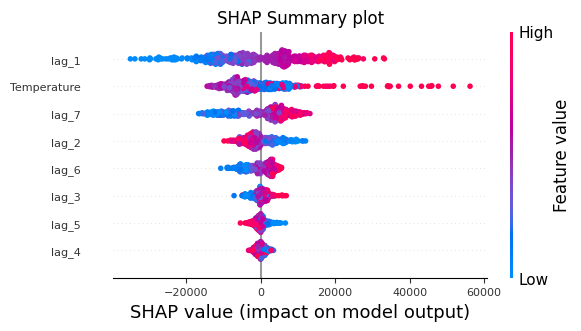

In [9]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 3)

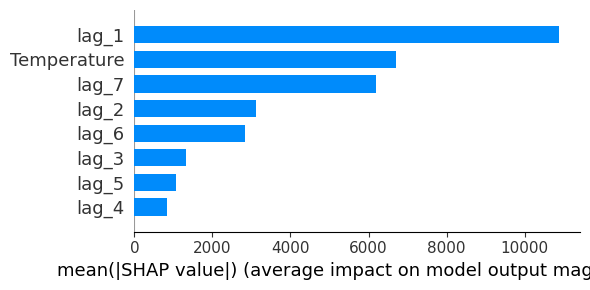

In [10]:
shap.summary_plot(shap_values, X_train_sample, plot_type="bar", plot_size=(6, 3))

#### SHAP Dependence Plots

SHAP dependence plots are visualizations used to understand the relationship between a feature and the model output by displaying how the value of a single feature affects predictions made by the model while considering interactions with other features. These plots are particularly useful for examining how a certain feature impacts the model's predictions across its range of values while considering interactions with other variables. 

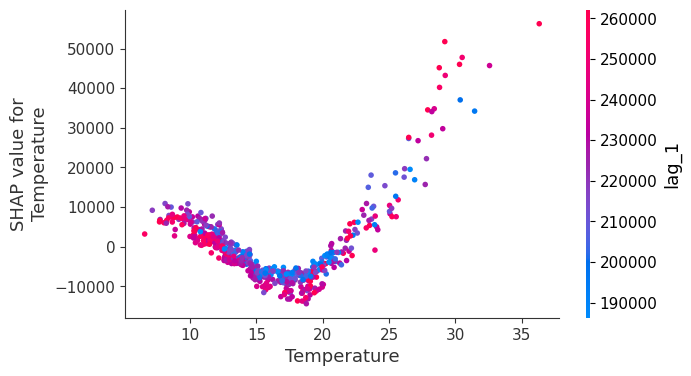

In [11]:
# Dependence plot for Temperature
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
shap.dependence_plot("Temperature", shap_values, X_train_sample, ax=ax)

### SHAP Explanations for Individual Predictions

SHAP values not only allow for interpreting the general behavior of the model (Global Interpretability) but also serve as a powerful tool for analyzing individual predictions (Local Interpretability). This is especially useful when trying to understand why a model made a specific prediction for a given instance.

To carry out this analysis, it is necessary to access the predictor values — lags and exogenous variables — at the time of the prediction. This can be achieved by using the `create_predict_X` method or by enabling the `return_predictors = True` argument in the `backtesting_forecaster` function.

#### SHAP values of predict output


Suppose the forecaster is employed to predict the next 10 values of the series, and a specific prediction corresponding to the date '2014-12-28' requires explanation.

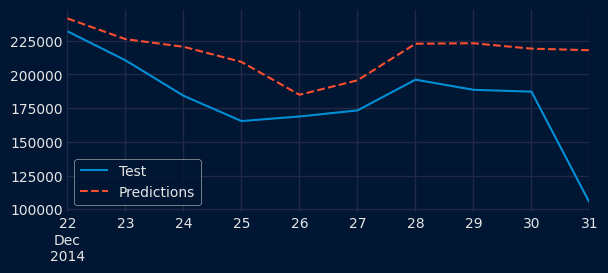

In [12]:
# Forecasting next 10 days
# ==============================================================================
set_dark_theme()

predictions = forecaster.predict(steps=10, exog=data_test['Temperature'])

fig, ax = plt.subplots(figsize=(6, 2.5))
data_test['Demand'].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions', linestyle='--')
ax.set_xlabel(None)
ax.legend();

The method `create_predict_X` is used to create the input matrix used internally by the forecaster's `predict` method. This matrix is then used to generate SHAP values for the forecasted values.

In [13]:
# Create input matrix used to forecast the next 10 steps
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=10, exog=data_test['Temperature'])
X_predict.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Temperature
2014-12-22,216483.631690,186486.896670,197129.766534,214934.022460,215507.677076,226093.767670,231923.044018,22.950000
2014-12-23,241514.532543,216483.631690,186486.896670,197129.766534,214934.022460,215507.677076,226093.767670,18.829167
2014-12-24,226165.936559,241514.532543,216483.631690,186486.896670,197129.766534,214934.022460,215507.677076,18.312500


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If transformations or differentiation are included in the Forecaster, the output matrix will be in the transformed scale. To obtain the SHAP values in the original scale, it is necessary to reverse the transformations or differentiation. For more information, visit: [Extract training and prediction matrices](../user_guides/training-and-prediction-matrices.html).

</div>

In [14]:
# SHAP values for the predictions
# ==============================================================================
shap_values = explainer.shap_values(X_predict)

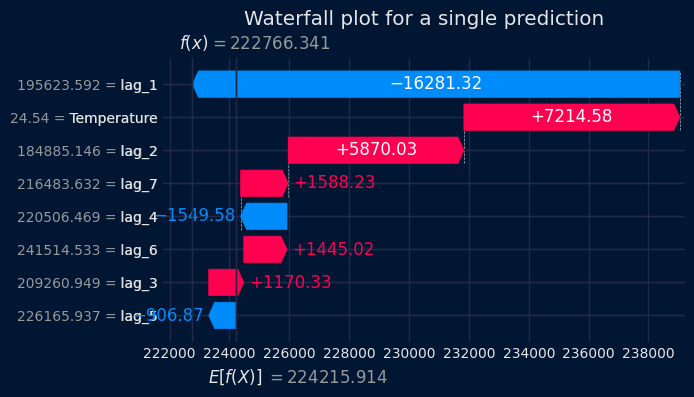

In [15]:
# Waterfall plot for a single prediction
# ==============================================================================
predicted_date = '2014-12-28'
iloc_predicted_date = X_predict.index.get_loc(predicted_date)

shap_values_single = explainer(X_predict)
shap.plots.waterfall(shap_values_single[iloc_predicted_date], show=False)

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 3.5)
ax_list = fig.axes
ax = ax_list[0]
ax.tick_params(labelsize=10)
ax.set_title("Waterfall plot for a single prediction")
plt.show()

The waterfall plot illustrates how different features pushed the model’s output higher (shown in red) or lower (shown in blue), relative to the average model prediction.

+ `lag_1` had the largest negative impact, reducing the prediction by over 16000 units.

+ `Temperature` contributed positively, increasing the prediction by around 7,214 units.

The model prediction (f(x)) was 222766.341, while the expected value (E[f(x)]) across all predictions is 224,215.914. This means the specific inputs for this prediction led the model to forecast a value lower than average, largely due to the strong negative impact of `lag_1`.

Same insights can be obtained using the `shap.force_plot method`.

In [16]:
# Forceplot for a single prediction 
# ==============================================================================
shap.force_plot(
    base_value  = explainer.expected_value,
    shap_values = shap_values_single.values[iloc_predicted_date],
    features    = X_predict.iloc[iloc_predicted_date, :]
)

In [17]:
# Force plot for the 10 predictions
# ==============================================================================
shap.force_plot(
    base_value  = explainer.expected_value,
    shap_values = shap_values,
    features    = X_predict
)

#### SHAP values of backtesting_forecaster() output

The analysis of individual predictions using SHAP values can be also apllied to predictions made in a backtesting process. For that, the `return_predictors=True` argument must be set in the `backtesting_forecaster` method. This will return a DataFrame with the predicted value ('pred'), the partition it belongs to ('fold'), and the value of the lags and exogenous variables used to make each prediction.

In this scenario, a backtesting process is employed to train the model using data up to '2014-12-01 23:59:00'. The model then generates predictions in folds of 24 steps. SHAP values are subsequently computed for the forecast corresponding to the date '2014-12-16'.

In [18]:
# Backtesting returning the predictors
# ==============================================================================
cv = TimeSeriesFold(steps= 24, initial_train_size = len(data.loc[:'2014-12-01 23:59:00']))
_, predictions = backtesting_forecaster(
                     forecaster        = forecaster,
                     y                 = data['Demand'],
                     exog              = data['Temperature'],
                     cv                = cv,
                     metric            = 'mean_absolute_error',
                     return_predictors = True,
                 )
predictions.head(3)

  0%|          | 0/2 [00:00<?, ?it/s]

,pred,fold,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Temperature
2014-12-02,231237.145266,0,237812.592388,234970.336660,189653.758108,202017.012448,214602.854760,218321.456402,214318.765210,19.833333
2014-12-03,227614.717135,0,231237.145266,237812.592388,234970.336660,189653.758108,202017.012448,214602.854760,218321.456402,19.616667
2014-12-04,229619.129116,0,227614.717135,231237.145266,237812.592388,234970.336660,189653.758108,202017.012448,214602.854760,21.702083


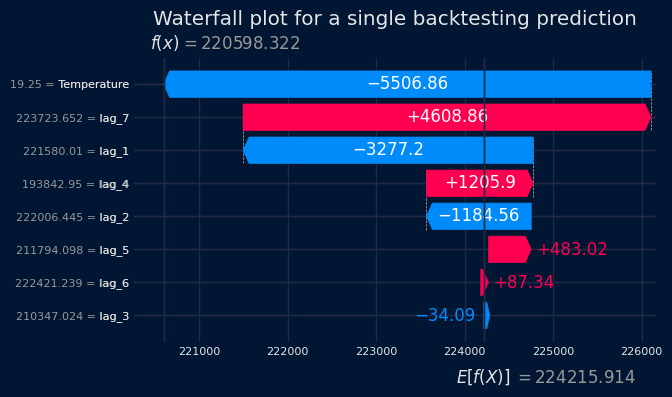

In [19]:
# Waterfall for a single prediction generated during backtesting
# ==============================================================================
predictions = predictions.astype(data['Temperature'].dtypes)  # Ensure that the types are the same
iloc_predicted_date = predictions.index.get_loc('2014-12-16')
shap_values_single = explainer(predictions.iloc[:, 2:])
shap.plots.waterfall(shap_values_single[iloc_predicted_date], show=False)

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(6, 3.5)
ax_list = fig.axes
ax = ax_list[0]
ax.tick_params(labelsize=8)
ax.set_title("Waterfall plot for a single backtesting prediction")
plt.show()

## Permutation feature importance

Permutation feature importance is a model inspection technique that measures the contribution of each feature to the statistical performance of a fitted model on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model's score. By breaking the relationship between the feature and the target variable, we determine how much the model relies on that particular feature.

In [20]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data_train['Demand'],
                       exog = data_train['Temperature']
                   )

# Permutation importances
# ==============================================================================
r = permutation_importance(
        estimator    = forecaster.regressor,
        X            = X_train,
        y            = y_train,
        n_repeats    = 3,
        max_samples  = 0.5,
        random_state = 123
    )

importances = pd.DataFrame({
                  'feature': X_train.columns,
                  'mean_importance': r.importances_mean,
                  'std_importance': r.importances_std
              }).sort_values('mean_importance', ascending=False)
importances

,feature,mean_importance,std_importance
0,lag_1,0.617276,0.014583
7,Temperature,0.411240,0.014405
6,lag_7,0.196190,0.001865
1,lag_2,0.122398,0.007803
5,lag_6,0.083912,0.003637
2,lag_3,0.041294,0.002019
4,lag_5,0.030787,0.001079
3,lag_4,0.024816,0.001021


## Partial dependence plots

Partial dependence plots (PDPs) are a useful tool for understanding the relationship between a feature and the target outcome in a machine learning model. In scikit-learn, you can create partial dependence plots using the `plot_partial_dependence` function. This function visualizes the effect of one or two features on the predicted outcome, while marginalizing the effect of all other features.

The resulting plots show how changes in the selected feature(s) affect the predicted outcome while holding other features constant on average. Remember that these plots should be interpreted in the context of your model and data. They provide insight into the relationship between specific features and the model's predictions.

A more detailed description of the Partial Dependency Plot can be found in <a href="https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-and-individual-conditional-expectation-plots">Scikitlearn&#39;s User Guides</a>.

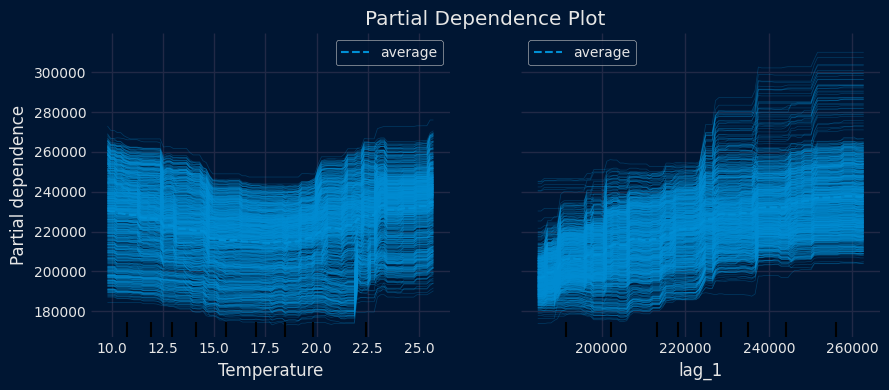

In [21]:
# Scikit-learn partial dependence plots
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_title("Decision Tree")
pd.plots = PartialDependenceDisplay.from_estimator(
    estimator = forecaster.regressor,
    X         = X_train,
    features  = ["Temperature", "lag_1"],
    kind      = 'both',
    ax        = ax,
)
ax.set_title("Partial Dependence Plot")
fig.tight_layout()
plt.show()